Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.batchnorm import BatchNorm1d
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

In [56]:
from torchvision.datasets import CIFAR10

# set up dataaset and dataloaders
trans = transforms.Compose([
    transforms.ToTensor()
])

train_data = CIFAR10(root='./datasets', train=True, download=True, transform=trans)
test_data = CIFAR10(root='./datasets', train=True, download=False, transform=trans)

train_loader = DataLoader(train_data,batch_size=64, shuffle=True, pin_memory=True)

test_loader = DataLoader(test_data,batch_size=64, shuffle=False, pin_memory=True)


Files already downloaded and verified


Text(0.5, 1.0, '8')

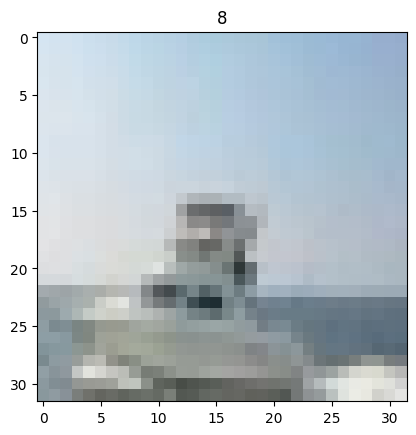

In [57]:
# visualize dataset 
train_data[0][0].shape 
plt.imshow(train_data[100][0].permute(1,2,0))
plt.title(train_data[100][1])

In [58]:
# create a new class
class VarAutoEncoderConv(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    # create the layers used in the encoder
    self.econv1 = nn.Conv2d(1, 32, 3, 2, 1)
    self.ebn1 = nn.BatchNorm2d(32) 
    self.econv2 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(64)
    self.econv3 = nn.Conv2d(64, 128, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(128)
    self.elinear1 = nn.Linear(64 * 4 * 4, 128)
    self.elinear2 = nn.Linear(128, 64)
    self.elinear3 = nn.Linear(64, nz)
    # create the layers in the decoder block
    self.dlinear1 = nn.Linear(nz, 64)
    self.dlinear2 = nn.Linear(64, 128)
    self.dlinear3 = nn.Linear(128, 64 * 4 * 4)
    self.deconv1 = nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1) #input_channel , out , filter , stride , padding 
    self.deconv2 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1)
    self.deconv3 = nn.ConvTranspose2d(32, 3, 3, 2, 1, output_padding=1)

    # adding batchnorm1d
    self.bnl2 = nn.BatchNorm1d(64) #1d linear
    self.bnl3 = nn.BatchNorm1d(128)
    
    # create the layers used in generating the mean and standard deviation
    self.slinear = nn.Linear(nz, nz) 
    self.ulinear = nn.Linear(nz, nz)

  # create the encoder block using the above created layers
  def encoder(self, x):
    x = F.leaky_relu(self.econv1(x)) #activation - leaky_relu
    x = self.ebn1(x)
    x = F.leaky_relu(self.econv2(x))
    x = self.ebn2(x)
    x = F.leaky_relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1, 64 * 4 * 4)
    x = torch.relu(self.elinear1(x))
    x = self.bnl3(x)
    x = torch.relu(self.elinear2(x))
    x = self.bnl2(x)
    x = torch.sigmoid(self.elinear3(x))
    return x

  # create the decoder block using the above create layers
  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.bnl2(x)
    x = torch.relu(self.dlinear2(x))
    x = self.bnl3(x)
    x = torch.relu(self.dlinear3(x))
    x = x.view(-1, 128, 4, 4)
    x = self.ebn3(x)
    x = F.leaky_relu(self.deconv1(x))
    x = self.ebn2(x)
    x = F.leaky_relu(self.deconv2(x))
    x = self.ebn1(x)
    x = torch.sigmoid(self.deconv3(x))
    return x
  
   # define a function to get the parameters for the decoding part
  def get_params(self, x): 
    u = torch.relu(self.ulinear(x))
    logvar = torch.relu(self.slinear(x))
    return u, logvar

  # define the reparametarization trick for getting z
  def reparametarization(self, u, logvar): 
    std = torch.exp(logvar/2)
    z = u + std * torch.rand_like(u) #d and ed
    return z

  # define the forward function
  def forward(self, x):
    ex = self.encoder(x)
    u, logvar = self.get_params(ex) 
    z = self.reparametarization(u, logvar) 
    x = self.decoder(z) 
    return z, x, u, logvar

In [59]:
# define loss function for the varautoencoder
def var_loss(X_hat, X, u, logvar):
  KLD_WEIGHT = 0.0001
  term1 = F.mse_loss(X_hat, X)
  term2 = torch.mean(torch.sum(0.5 * (1 + logvar - torch.exp(logvar) - u**2), axis=1), axis=0)
  return (1 - KLD_WEIGHT) * term1 - (KLD_WEIGHT * term2)

We train the VAE to try and compare between the grayscale images as input to the generated colour imgaes. We evalutae its performance via comparing the actual coloured image with the generated colour images

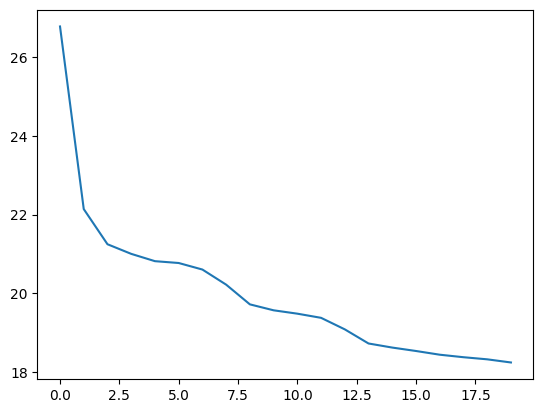

In [93]:
device = torch.device("cuda:0")
net =  VarAutoEncoderConv(15).to(device)
opt = optim.Adam(net.parameters(), lr = 1e-2)
epochs = 20
ls = []
for i in range(epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    # create grayscale transform
    gray = transforms.Grayscale()
    X_gray = torch.zeros(X.shape)
    # convert images to grayscale
    X_gray = gray(X[:,:,:,:])
    z, Xhat, u, logvar = net(X_gray)
    loss = var_loss(Xhat, X, u, logvar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss)

plt.plot(ls)

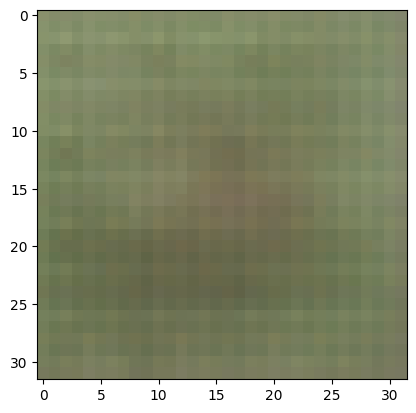

In [100]:
#test
# evaluate images of the model
net.eval()
z = torch.randn(64, 15).to(device)
X_hat = net.decoder(z)
plt.imshow(X_hat[0,:,:,:].permute(1, 2, 0).detach().cpu().numpy())